In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu'
sys.path.append(os.getcwd()+"/..")
sys.path.append(os.getcwd()+"/dcgan/")

import theano.tensor as T
import theano

import lasagne

from tasks import check
from scripts import manifold
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from image_scatter import image_scatter
from tqdm import tqdm

%matplotlib inline
from IPython.display import Image

import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

def floatX(x):
    return x.astype(np.float32)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Couldn't import dot_parser, loading of dot files will not be possible.


/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load model

In [2]:
#5a59f5a7094a3b585818e8e2117585c7
v = check(
    what="notebook", 
    filename="../training/mnist/mnist27/model.pkl", 
    #filename="../training/initial_models/model_E.pkl",
    dataset='digits',
    #force_w=28,
    #force_h=28,
    #force_c=1,
    #mode='minibatch'
    #force_model_params=dict(use_wta_spatial=False, use_wta_channel=False)
)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': u'adadelta'}


In [3]:
capsule, data, layers, w, h, c = v

In [4]:
for l in layers:
    print(l)

input
conv1
conv2
conv3
wta_spatial_conv1
wta_channel_conv1
wta_spatial_conv2
wta_channel_conv2
wta_spatial_conv3
wta_channel_conv3
out1
out2
out3
output


In [5]:
code_layers = ['wta_channel_conv1', 'wta_channel_conv2', 'wta_channel_conv3']
#code_layers = ['wta_channel']
#code_layers = ['wta_channel_conv1', 'wta_channel_conv2']

X = T.tensor4()
encode = theano.function(
    [X], 
    [L.get_output(layers[cc], X) for cc in code_layers]
)

code_t = [T.tensor4() for _ in code_layers]

decode = theano.function(
    code_t,
    L.get_output(layers['output'], {layers[name]: t for name, t in zip(code_layers, code_t)})
)

## viz features

conv1


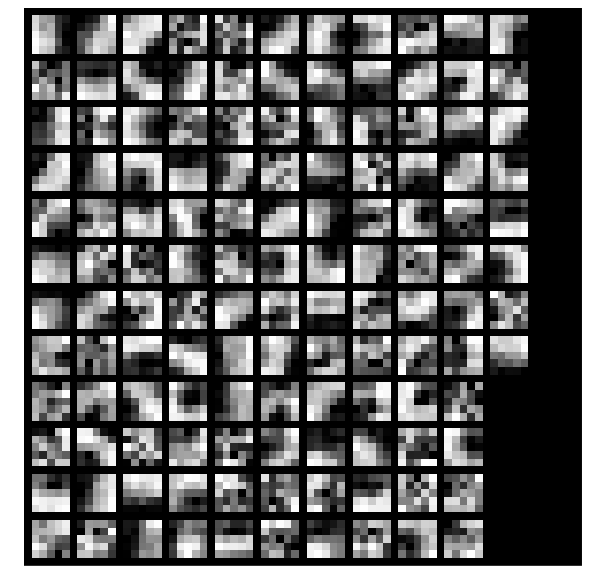

(128, 128, 5, 5)
(128, 128, 5, 5)
out1


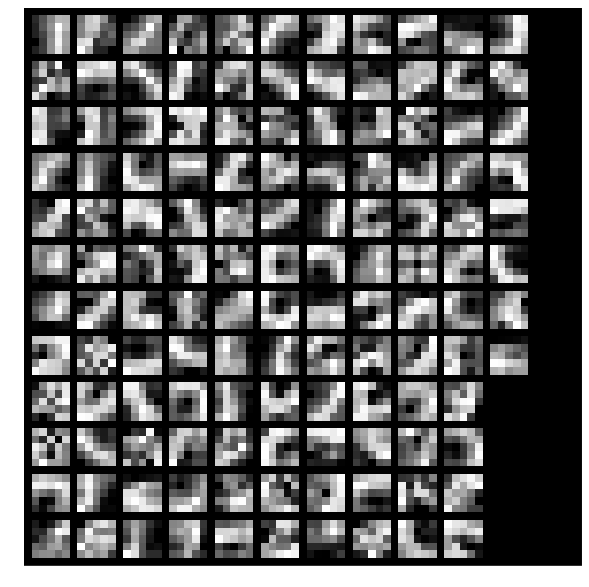

out2


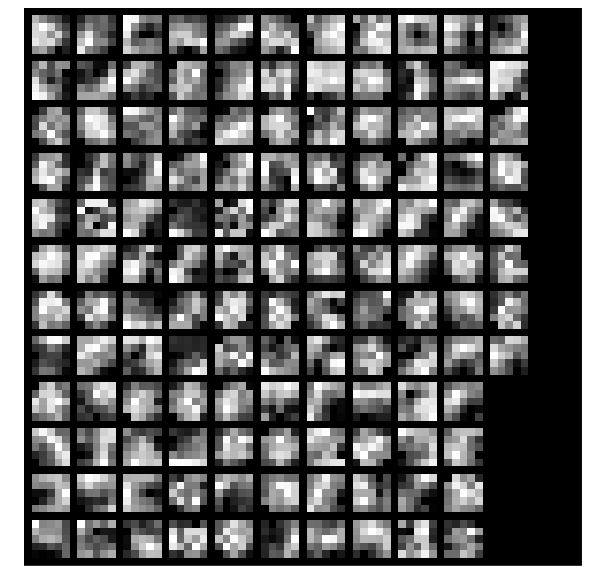

out3


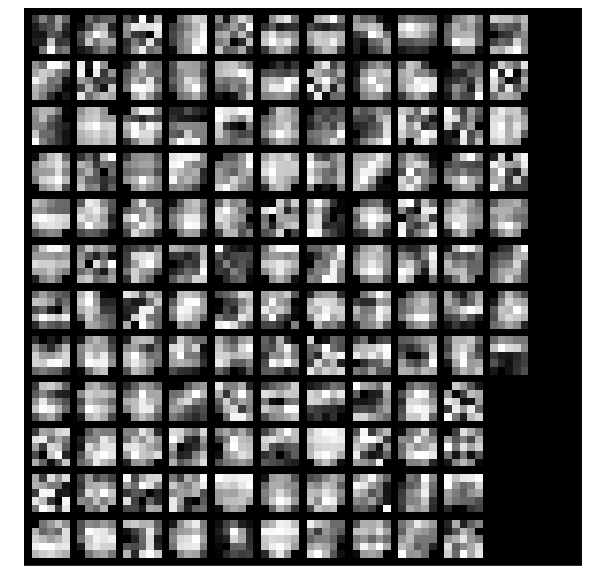

In [6]:
nbpixels = 28*28
for name, layer in layers.items():
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2 and (W.shape[0] == nbpixels or W.shape[1] == nbpixels):
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            W = W.reshape((W.shape[0], c, w, h))
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[1] in (1, 3):
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[0] in (1, 3):
            W = W.transpose((1, 2, 3, 0))
            W = W * np.ones((1, 1, 1, 3))
        else:
            print(W.shape)
            continue
        print(layer.name)
        fig = plt.figure(figsize=(10, 10))
        plt.axis('off')
        img = dispims_color(W, border=1)
        plt.imshow(img, interpolation='none')
        plt.show()

In [7]:
X = data.X[0:100]
X=capsule.preprocess(X)

In [8]:
Xrec = capsule.reconstruct(X)

In [19]:
C = encode(X)
Xrec = decode(*C)

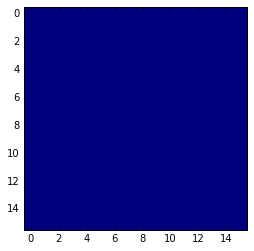

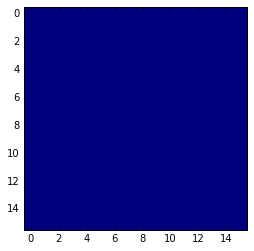

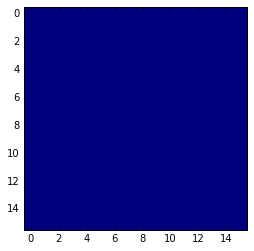

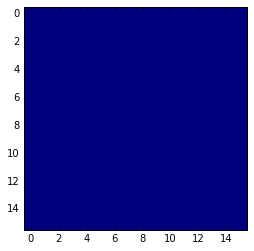

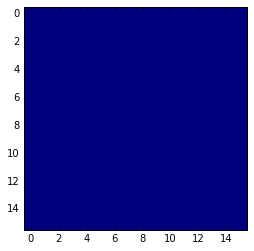

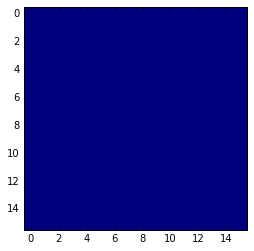

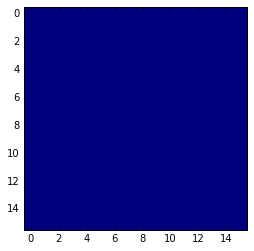

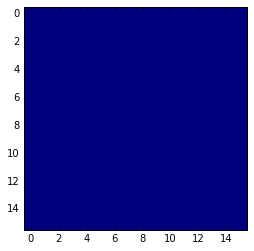

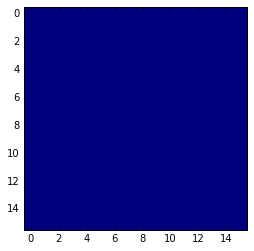

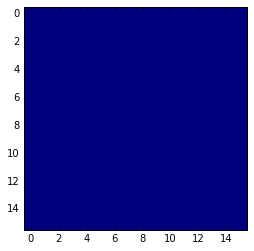

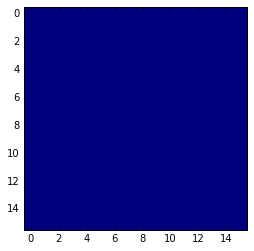

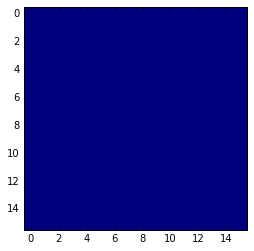

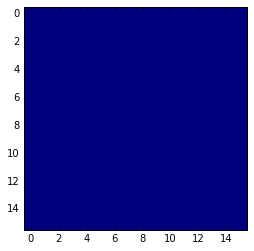

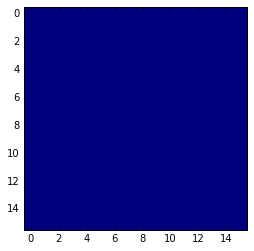

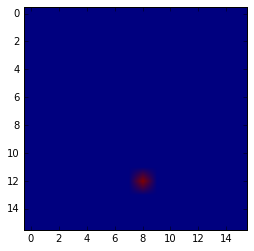

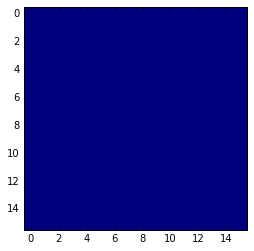

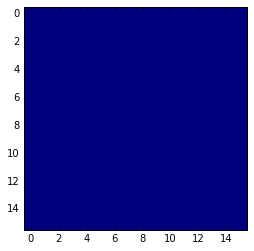

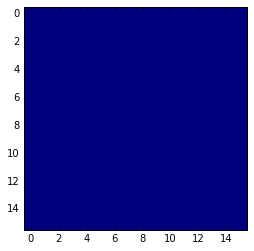

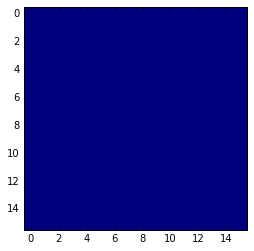

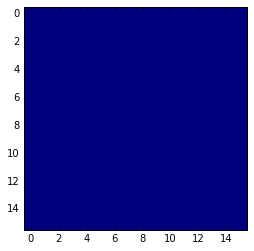

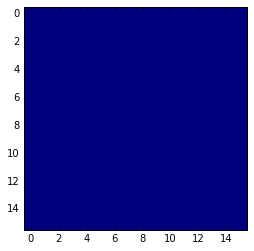

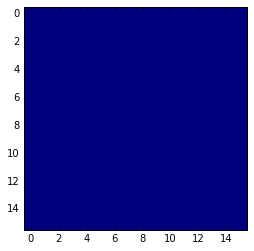

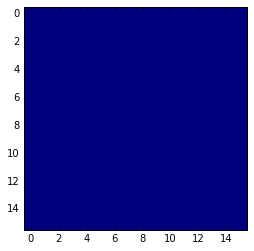

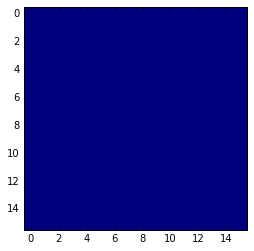

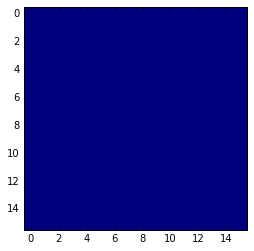

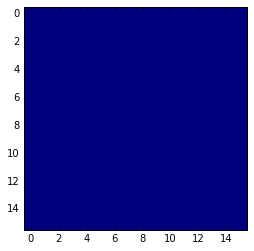

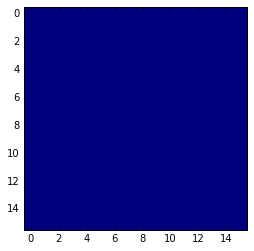

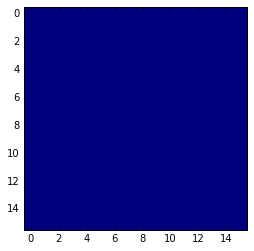

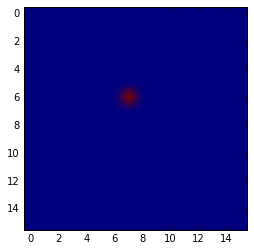

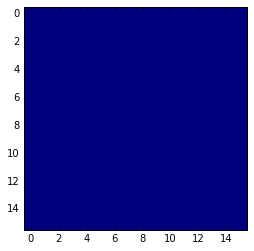

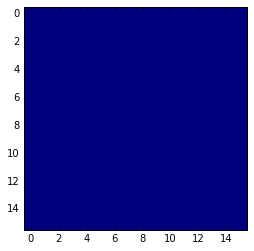

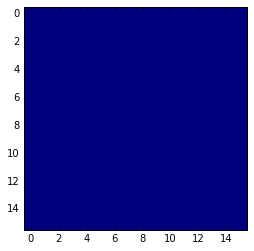

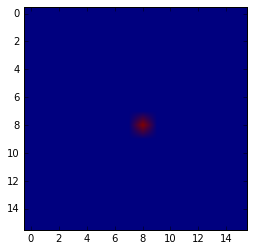

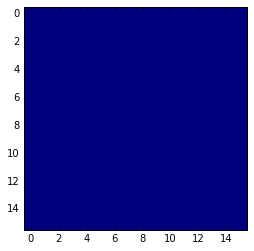

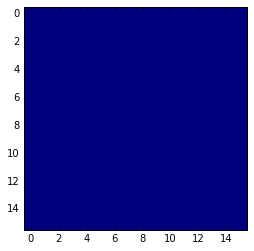

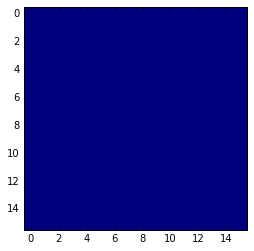

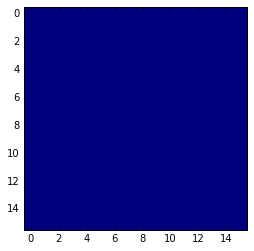

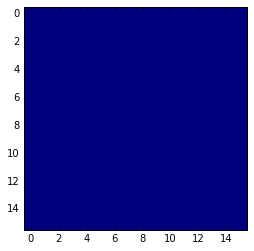

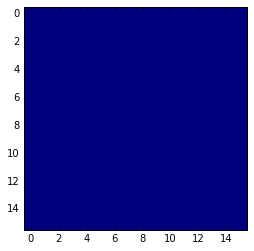

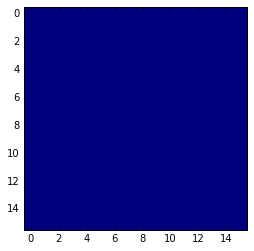

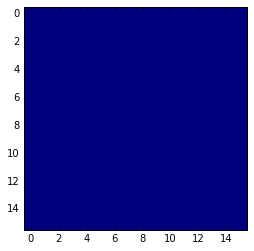

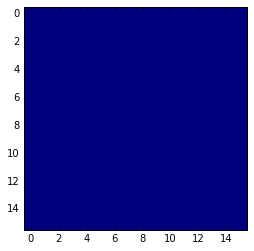

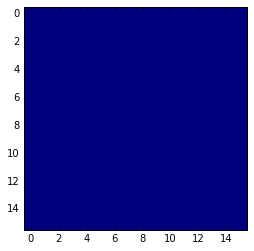

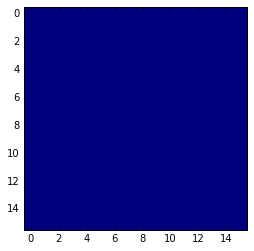

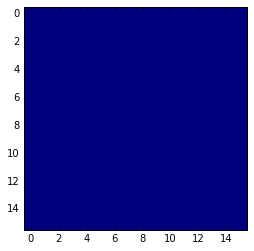

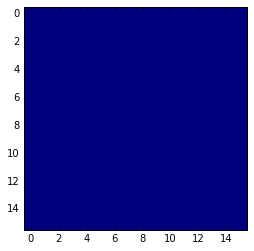

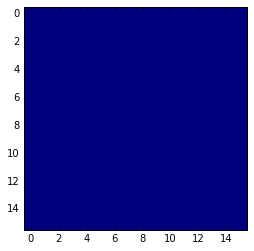

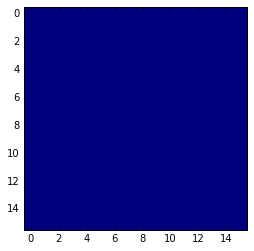

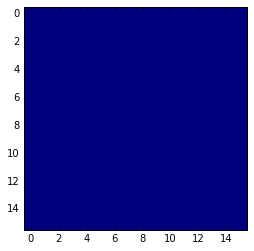

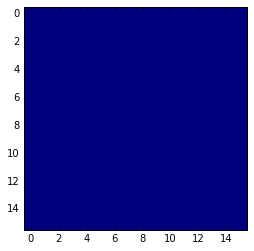

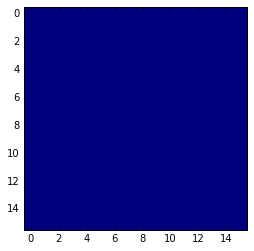

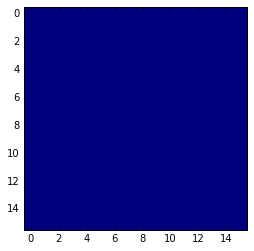

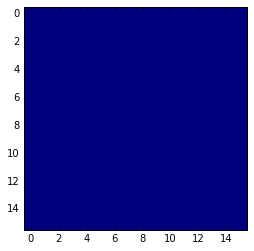

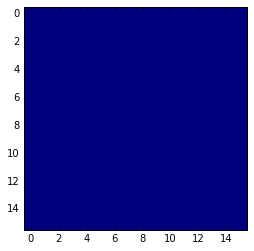

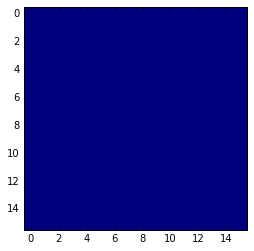

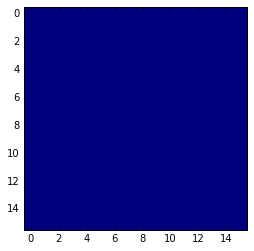

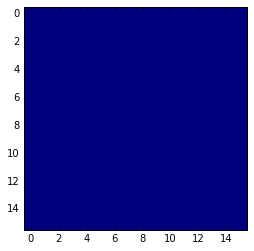

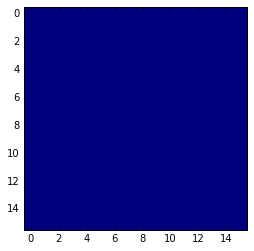

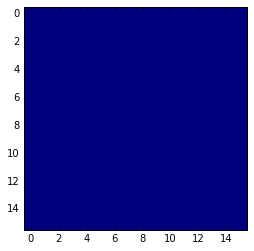

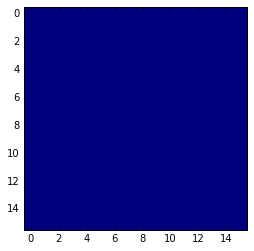

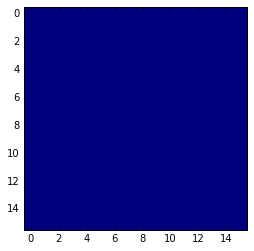

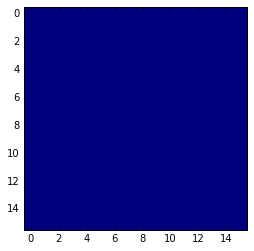

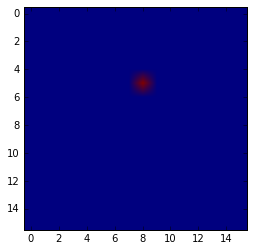

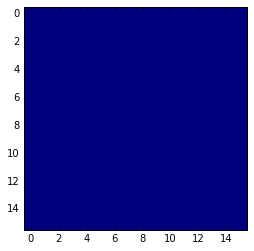

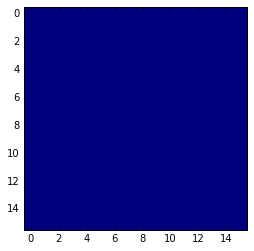

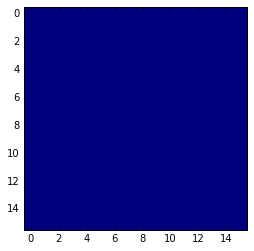

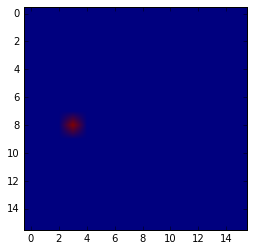

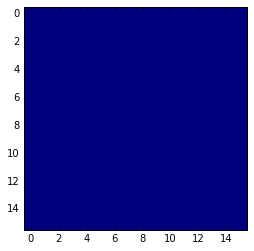

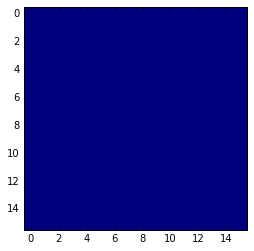

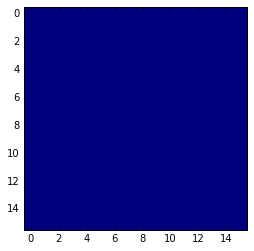

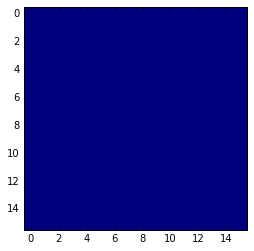

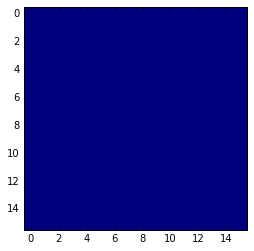

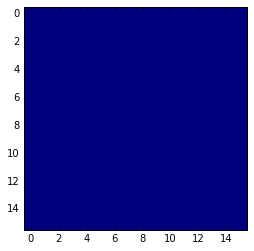

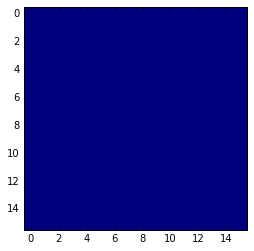

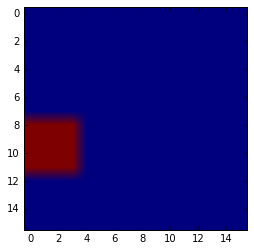

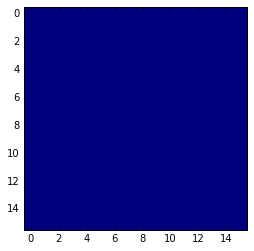

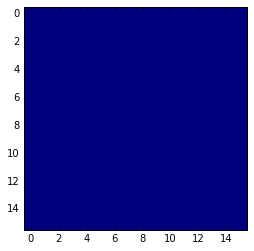

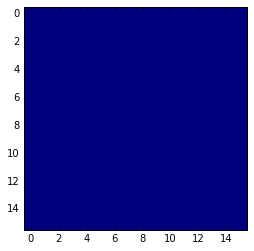

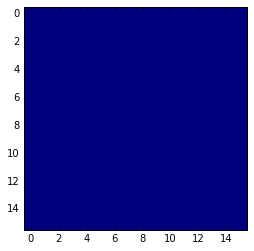

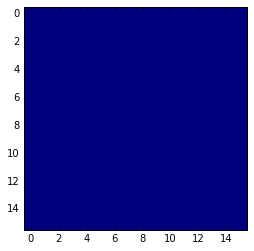

KeyboardInterrupt: 

In [27]:
for c in C[2]:
    plt.imshow(c[0])
    plt.show()

(array([  2.68300000e+03,   1.48000000e+02,   4.70000000e+01,
          2.00000000e+01,   6.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([  4.37721610e-08,   3.24278199e+01,   6.48556397e+01,
          9.72834595e+01,   1.29711279e+02,   1.62139099e+02,
          1.94566919e+02,   2.26994739e+02,   2.59422559e+02,
          2.91850378e+02,   3.24278198e+02]),
 <a list of 10 Patch objects>)

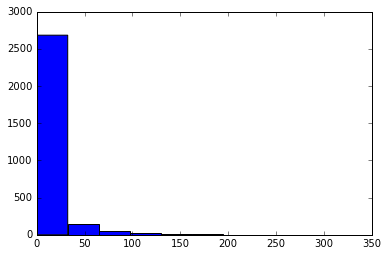

In [10]:
a=C[2].flatten()
a=a[a>0]
plt.hist(a)

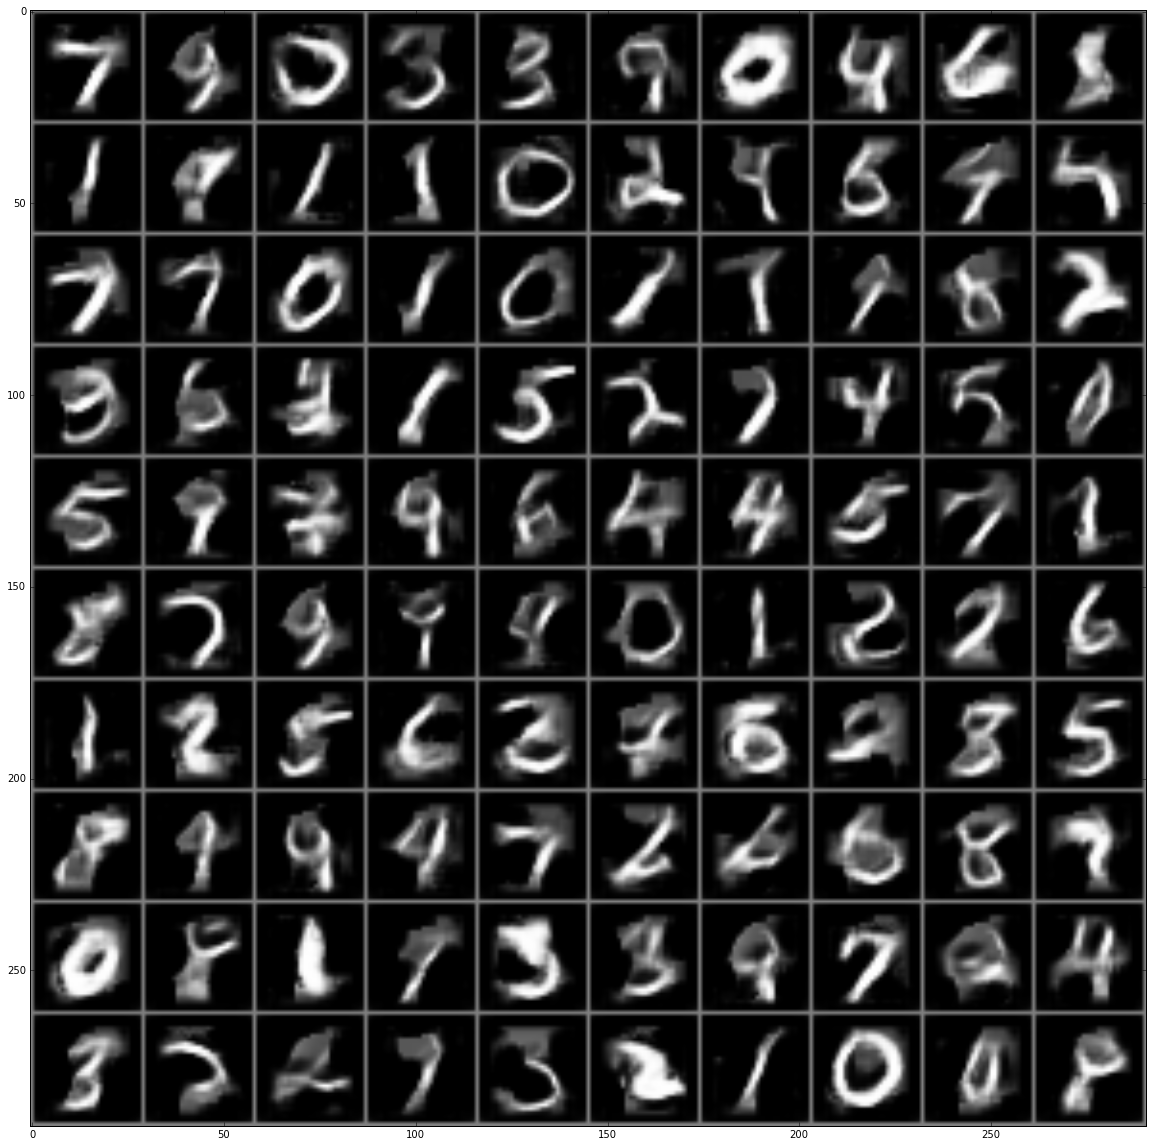

In [36]:
C = list(encode(X))
cc = [0, 1]
for i in cc:
    C[i][:] = 0
    
"""
M = (1,)
for i in M:
    F = C[i].shape[1]
    W = C[i].shape[2]
    H = C[i].shape[3]
    C[i][np.arange(C[i].shape[0]), 
         np.random.randint(0, F, size=C[i].shape[0]), 
         np.random.randint(0, W, size=C[i].shape[0]), 
         np.random.randint(0, H, size=C[i].shape[0])] = 100
"""

fig = plt.figure(figsize=(20, 20))
Xrec = decode(*C)
recons = dispims_color(Xrec.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1, bordercolor=(0.5,0.5,0.5))
plt.imshow(recons)

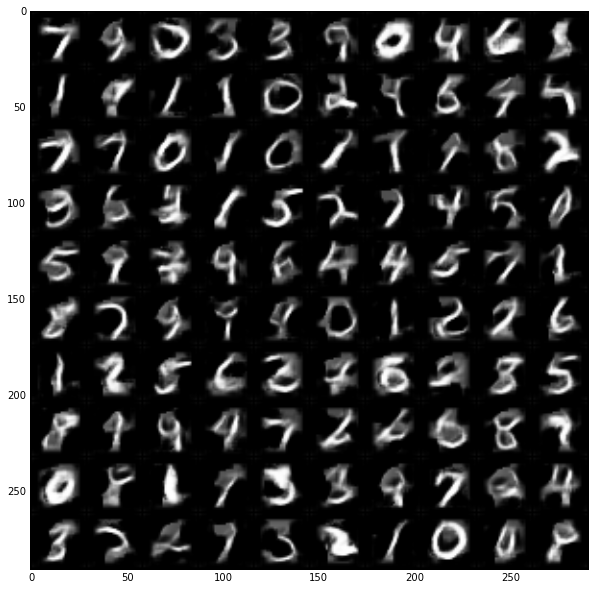

In [37]:
orig = dispims_color(X.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
recons = dispims_color(Xrec.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1)
imsave('orig.png', orig)
imsave('recons.png', recons)
fig = plt.figure(figsize=(10, 10))
plt.imshow(recons)

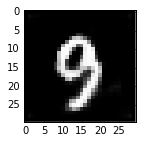

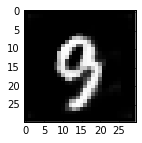

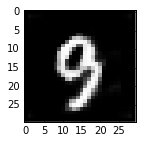

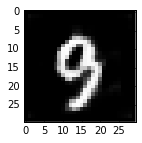

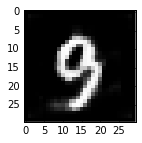

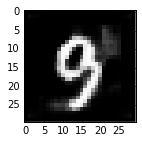

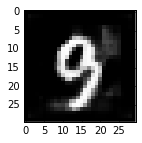

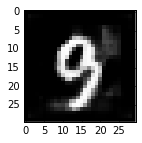

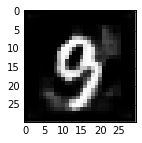

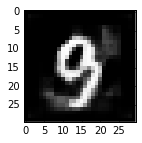

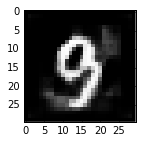

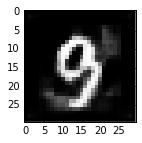

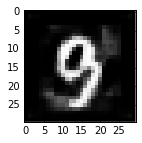

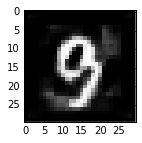

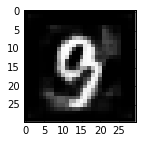

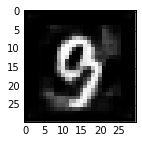

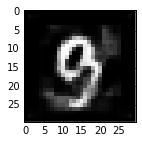

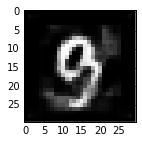

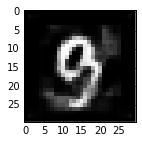

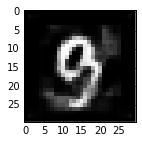

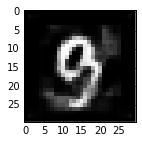

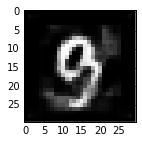

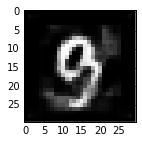

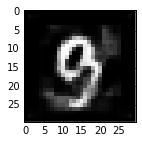

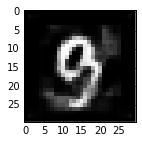

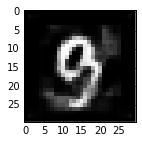

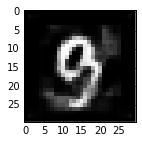

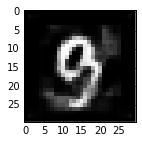

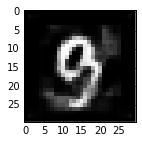

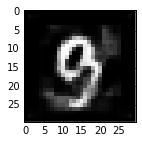

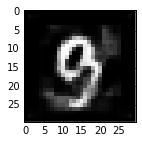

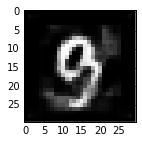

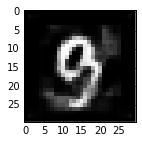

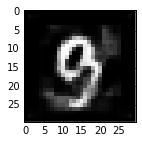

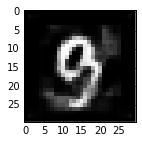

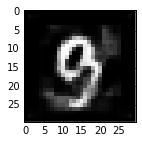

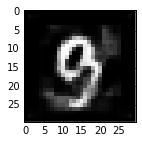

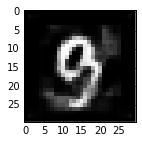

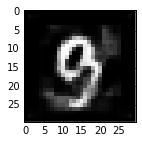

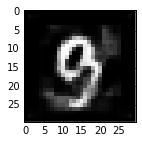

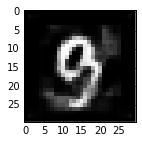

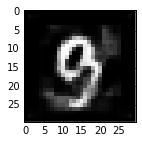

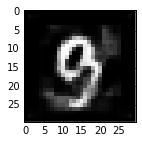

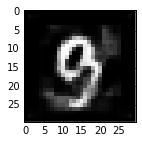

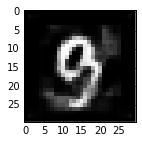

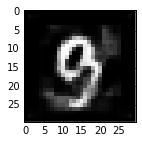

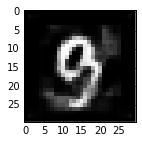

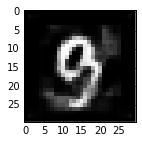

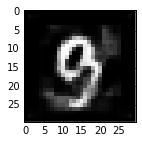

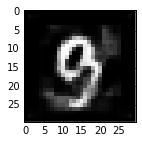

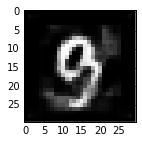

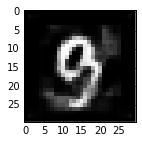

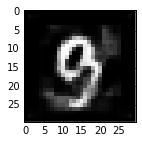

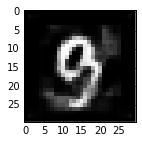

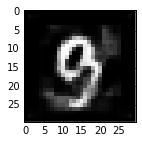

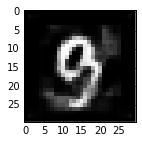

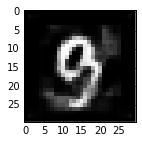

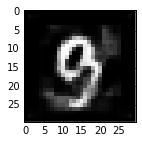

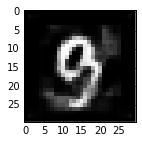

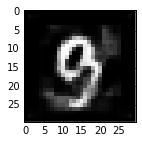

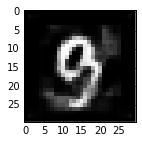

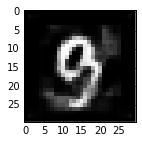

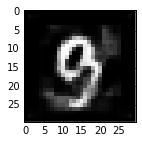

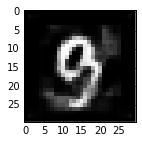

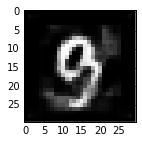

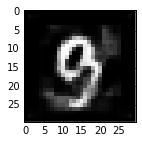

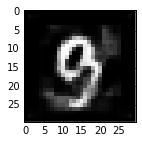

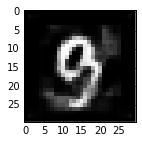

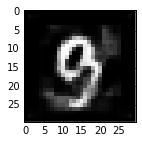

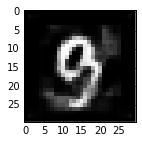

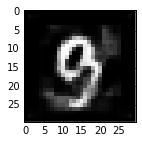

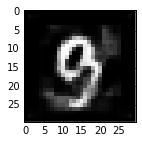

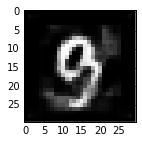

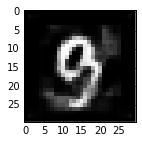

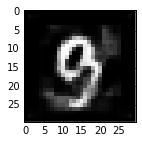

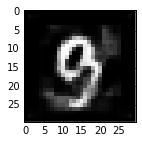

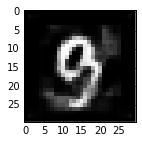

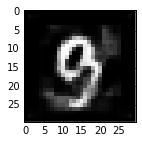

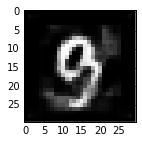

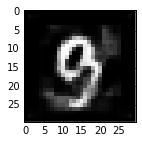

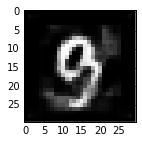

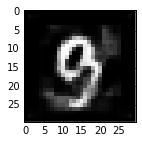

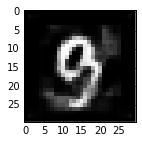

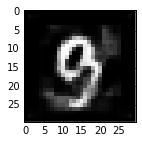

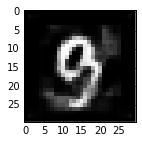

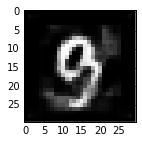

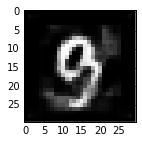

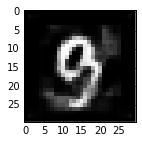

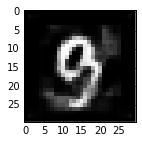

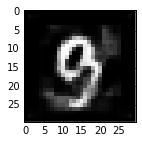

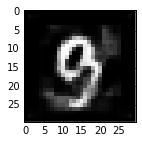

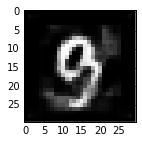

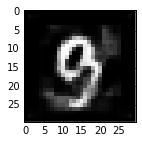

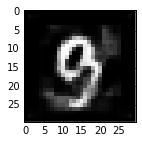

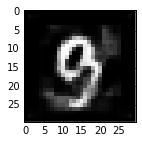

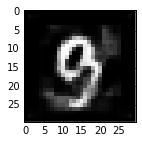

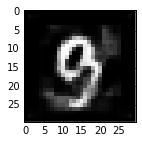

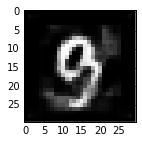

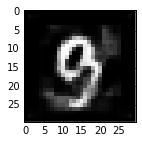

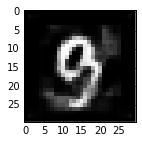

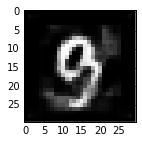

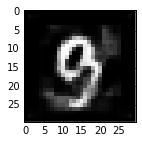

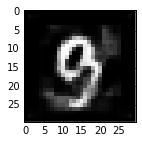

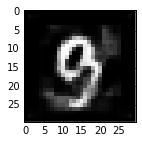

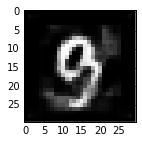

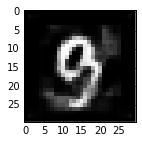

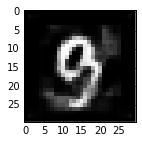

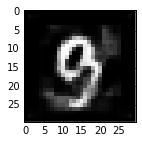

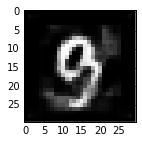

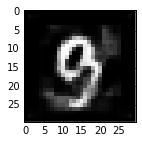

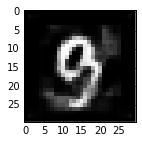

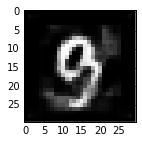

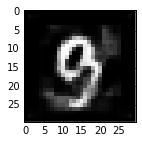

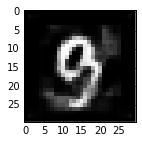

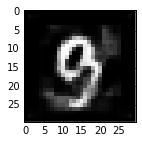

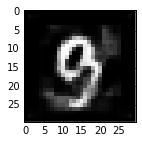

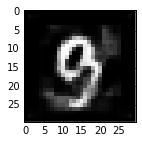

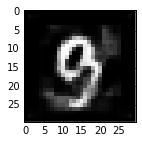

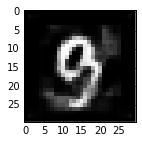

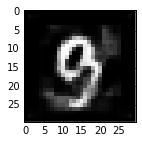

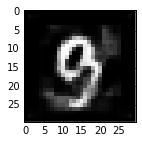

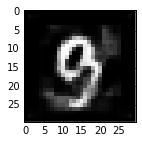

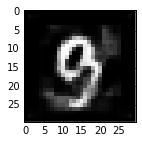

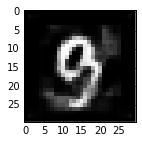

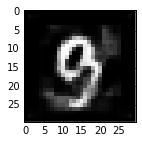

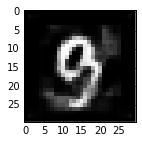

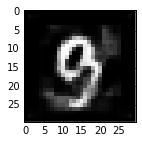

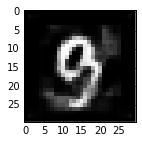

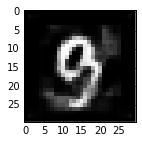

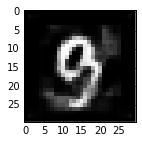

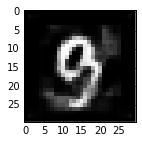

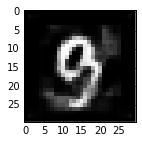

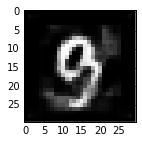

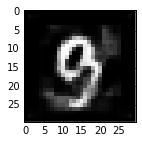

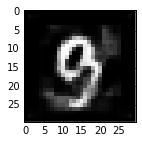

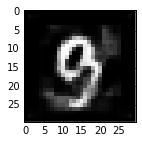

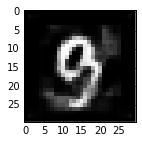

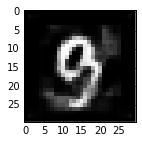

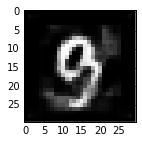

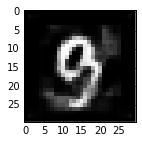

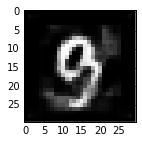

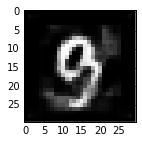

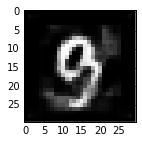

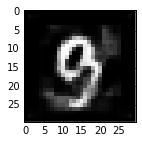

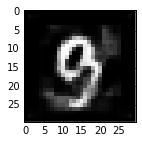

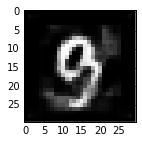

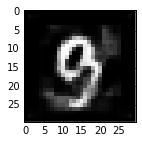

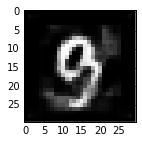

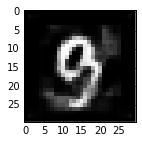

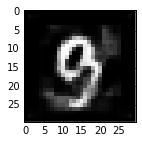

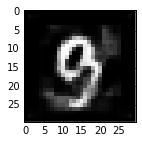

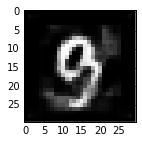

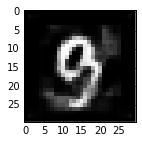

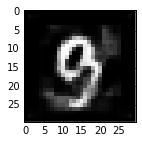

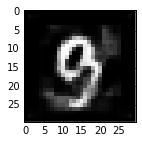

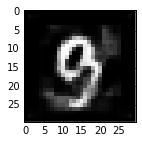

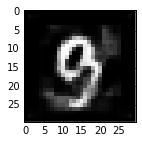

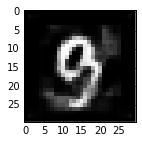

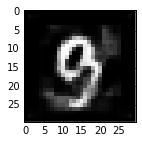

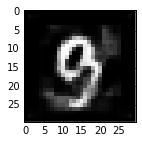

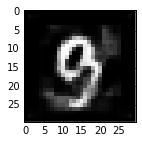

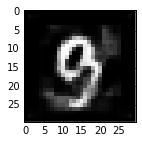

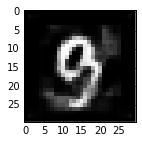

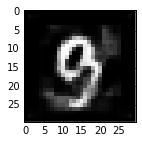

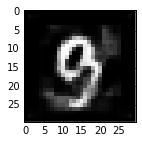

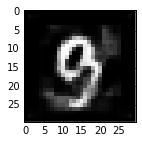

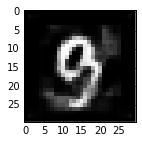

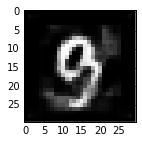

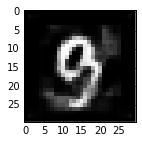

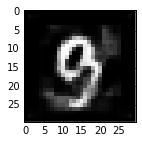

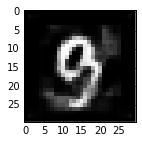

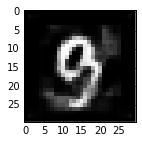

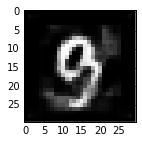

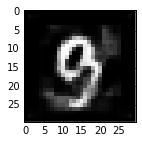

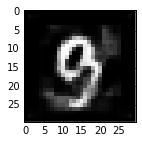

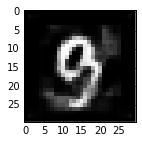

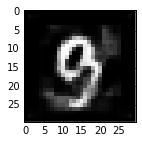

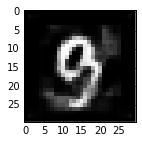

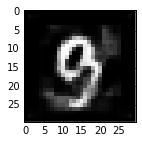

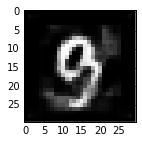

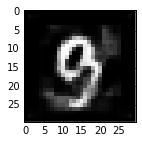

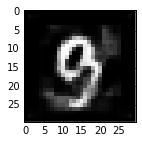

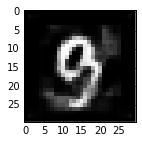

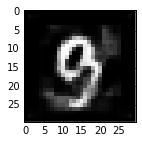

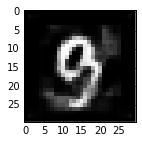

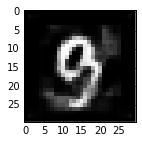

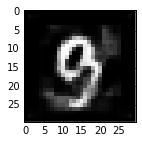

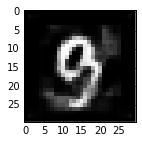

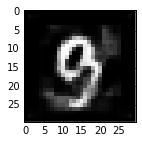

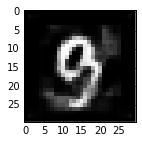

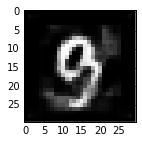

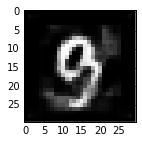

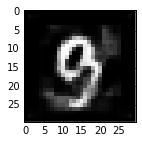

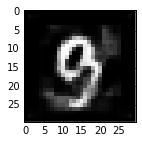

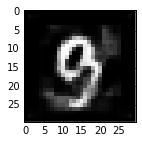

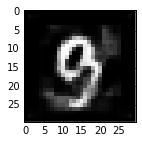

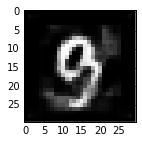

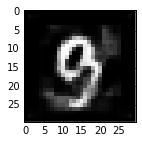

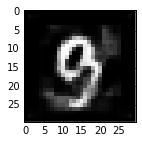

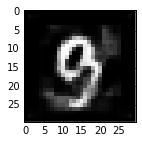

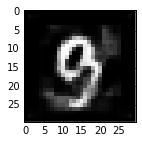

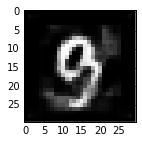

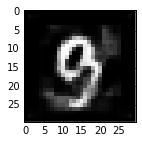

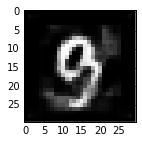

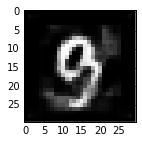

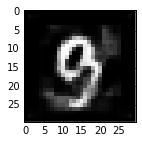

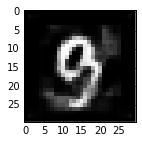

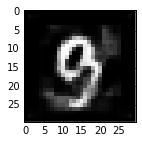

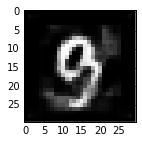

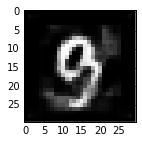

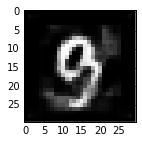

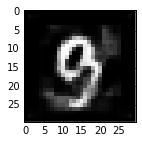

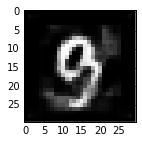

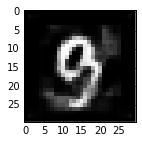

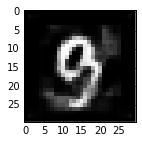

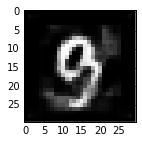

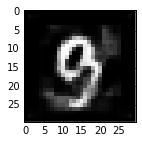

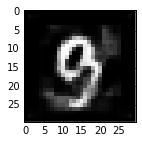

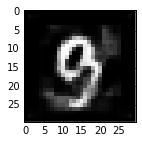

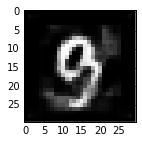

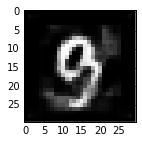

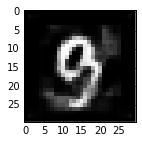

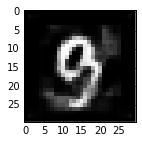

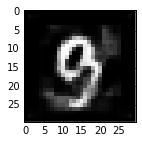

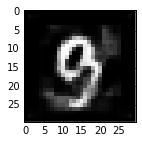

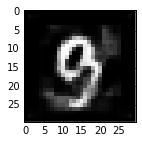

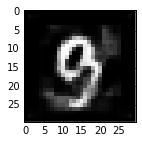

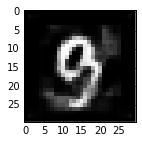

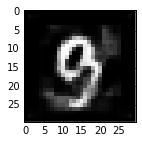

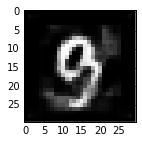

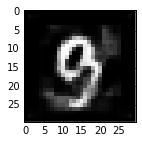

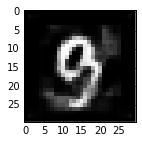

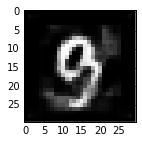

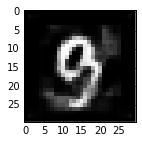

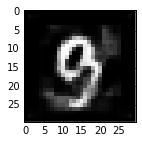

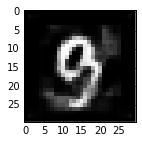

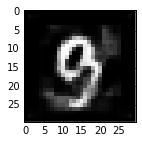

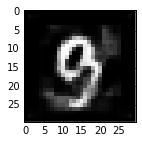

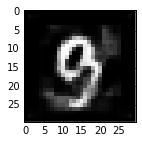

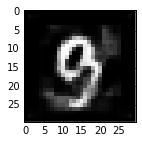

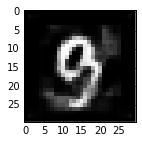

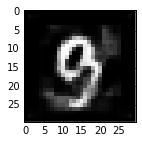

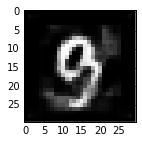

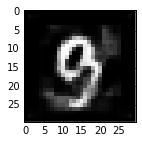

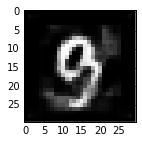

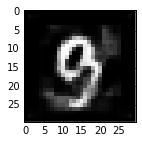

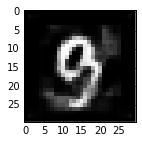

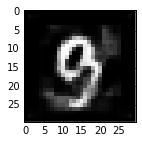

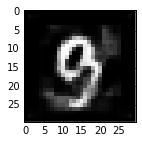

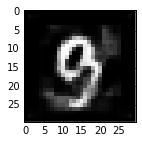

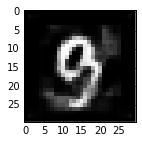

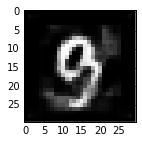

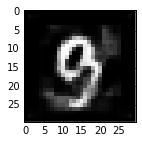

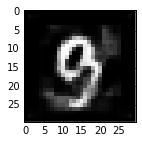

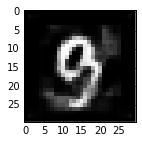

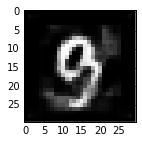

In [17]:
for i in range(256):
    xx = X[10:11]
    a, b, c = encode(xx)
    inds = c.max(axis=(2, 3)) > 0
    inds = np.arange(c.shape[1])[inds[0]]
    
    #for m in range(i):
    #    plt.imshow(c[0, inds[m]])
    #    plt.show()
    c[0, inds[0:i]] = 0
    C = [a, b, c]
    Xrec = decode(*C)

    #orig = dispims_color(xx.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
    
    recons = dispims_color(Xrec.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1)
    #imsave('orig.png', orig)
    #imsave('recons.png', recons)
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(recons, interpolation='none')
    plt.show()

## iterative refinement

In [20]:
from data import load_data
c=1
if c == 3:
    external_data = load_data(dataset='lfw', w=w, h=h)
    external_data = external_data.X
    external_data = external_data.reshape((external_data.shape[0], c, w, h))
    
if c == 1:
    from lasagnekit.datasets.rescaled import Rescaled
    external_data = load_data(dataset='digits', w=w, h=h)
    external_data = Rescaled(external_data, (w, h))
    external_data.load()
    external_data = external_data.X[0:100]
    external_data = external_data.reshape((external_data.shape[0], c, w, h))
    external_data = external_data.astype(np.float32)

genetic = False
if genetic:
    external_data = np.random.uniform(size=external_data.shape).astype(np.float32)

    layer_name = 'wta_spatial'
    x = T.tensor4()
    px_to_code = theano.function(
        [x],
        L.get_output(layers[layer_name], x)
    )
    code_to_px = theano.function(
        [x],
        L.get_output(layers["output"], {layers[layer_name]: x}))

    def crossover(A, nb=100):
        S = np.zeros((nb,) + A.shape[1:])
        for i in range(nb):
            ind1, ind2 = np.random.randint(0, A.shape[0], size=2)
            s1, s2 = A[ind1], A[ind2]
            s = np.zeros_like(s1)
            c = np.random.randint(0, 2, size=A.shape[1])
            s[c == 0] = s1[c == 0]
            s[c == 1] = s2[c == 1]
            S[i] = s
        return S.astype(np.float32)

    def smarter_mutation(A, born_perc=0.1, dead_perc=0.1, nbtimes=1, val=10, nb=100):
        # val = A.max()
        perc = born_perc + dead_perc
        nb_filters = A.shape[1]
        size = int(perc * nb_filters)
        for i in range(nbtimes):
            for a in A:
                indices = np.random.choice(np.arange(a.shape[1]),#was a  bug in the old genetic
                                           size=size, replace=True)
                nb_born = int(born_perc*nb_filters)
                born_indices = indices[0:nb_born]
                dead_indices = indices[nb_born:]
                a[dead_indices] = 0
                for idx in born_indices:
                    a[idx] = 0
                    x, y = np.random.randint(a.shape[1]), np.random.randint(a.shape[2])
                    # val = np.random.choice((0.01, 0.1, 1, 10))
                    #val = np.random.uniform()
                    a[idx, x, y] = val
        return A


    codes = px_to_code(external_data)
    codes = crossover(codes, nb=codes.shape[0])
    codes = smarter_mutation(codes, born_perc=0, dead_perc=0.9)
    external_data = code_to_px(codes)

In [26]:
seed = 42
np.random.seed(seed)
N = 100 # nb of examples to generate
nb_iter = 100 # nb iterations for generation
do_sample = True
do_binarize = True
do_noise = False
noise_pr = 0.5
init_by_external = False

if init_by_external:
    s = floatX(external_data[0:N])
else:
    s = floatX(np.random.uniform(0, 1, size=(N, c, w, h)) > 0.8)
print(s.shape)
samples = []
samples.append(s.copy()[np.newaxis, :, :, :, :])

loss = []
for i in tqdm(range(nb_iter)):
    sprev = s      
    if do_noise:
        s = (np.random.uniform(size=s.shape) <= (1 - noise_pr)) * s
        s = s.astype(np.float32)
    s = (capsule.reconstruct(s))
    samples.append(s.copy()[np.newaxis, :, :, :, :])

    if do_sample:
        s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    if do_binarize:
        s = s > 0.5
    score = np.abs(s - sprev).sum()
    print(score)
    if score == 0:
        break
    #print(score)
    loss.append(score)
samples = np.concatenate(samples, axis=0) # all samples from all timesteps in an array

(100, 1, 28, 28)


  0%|          | 0/100 [00:00<?, ?it/s]

20102.0


  1%|          | 1/100 [00:00<01:05,  1.52it/s]/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


12502


  2%|▏         | 2/100 [00:01<01:04,  1.52it/s]

10597


  3%|▎         | 3/100 [00:01<01:03,  1.52it/s]

9455


  4%|▍         | 4/100 [00:02<01:03,  1.52it/s]

8560


  5%|▌         | 5/100 [00:03<01:02,  1.52it/s]

8027


  6%|▌         | 6/100 [00:03<01:01,  1.52it/s]

7668


  7%|▋         | 7/100 [00:04<01:01,  1.52it/s]

7345


  8%|▊         | 8/100 [00:05<01:00,  1.52it/s]

6927


  9%|▉         | 9/100 [00:05<00:59,  1.52it/s]

6710


 10%|█         | 10/100 [00:06<00:59,  1.52it/s]

6521


 11%|█         | 11/100 [00:07<00:58,  1.52it/s]

6226


 12%|█▏        | 12/100 [00:07<00:57,  1.52it/s]

5995


 13%|█▎        | 13/100 [00:08<00:57,  1.53it/s]

5863


 14%|█▍        | 14/100 [00:09<00:56,  1.53it/s]

5756


 15%|█▌        | 15/100 [00:09<00:55,  1.53it/s]

5593


 16%|█▌        | 16/100 [00:10<00:55,  1.53it/s]

5472


 17%|█▋        | 17/100 [00:11<00:54,  1.53it/s]

5266


 18%|█▊        | 18/100 [00:11<00:53,  1.53it/s]

5383


 19%|█▉        | 19/100 [00:12<00:53,  1.53it/s]

5262


 20%|██        | 20/100 [00:13<00:52,  1.53it/s]

5290


 21%|██        | 21/100 [00:13<00:51,  1.53it/s]

5195


 22%|██▏       | 22/100 [00:14<00:51,  1.53it/s]

5134


 23%|██▎       | 23/100 [00:15<00:50,  1.53it/s]

5181


 24%|██▍       | 24/100 [00:15<00:49,  1.52it/s]

4984


 25%|██▌       | 25/100 [00:16<00:49,  1.52it/s]

4931


 26%|██▌       | 26/100 [00:17<00:48,  1.53it/s]

4947


 27%|██▋       | 27/100 [00:17<00:47,  1.52it/s]

4838


 28%|██▊       | 28/100 [00:18<00:47,  1.52it/s]

4847


 29%|██▉       | 29/100 [00:19<00:46,  1.52it/s]

4849


 30%|███       | 30/100 [00:19<00:45,  1.52it/s]

4825


 31%|███       | 31/100 [00:20<00:45,  1.52it/s]

4863


 32%|███▏      | 32/100 [00:20<00:44,  1.52it/s]

4780


 33%|███▎      | 33/100 [00:21<00:43,  1.52it/s]

4807


 34%|███▍      | 34/100 [00:22<00:43,  1.52it/s]

4834


 35%|███▌      | 35/100 [00:22<00:42,  1.52it/s]

4803


 36%|███▌      | 36/100 [00:23<00:41,  1.52it/s]

4828


 37%|███▋      | 37/100 [00:24<00:41,  1.52it/s]

4951


 38%|███▊      | 38/100 [00:24<00:40,  1.52it/s]

4982


 39%|███▉      | 39/100 [00:25<00:40,  1.52it/s]

4897


 40%|████      | 40/100 [00:26<00:39,  1.52it/s]

4952


 41%|████      | 41/100 [00:26<00:38,  1.52it/s]

4905


 42%|████▏     | 42/100 [00:27<00:38,  1.52it/s]

4873


 43%|████▎     | 43/100 [00:28<00:37,  1.52it/s]

4759


 44%|████▍     | 44/100 [00:28<00:36,  1.52it/s]

4958


 45%|████▌     | 45/100 [00:29<00:36,  1.52it/s]

4893


 46%|████▌     | 46/100 [00:30<00:35,  1.52it/s]

4865


 47%|████▋     | 47/100 [00:30<00:34,  1.52it/s]

4810


 48%|████▊     | 48/100 [00:31<00:34,  1.52it/s]

4749


 49%|████▉     | 49/100 [00:32<00:33,  1.52it/s]

4739


 50%|█████     | 50/100 [00:32<00:32,  1.52it/s]

4832


 51%|█████     | 51/100 [00:33<00:32,  1.52it/s]

4693


 52%|█████▏    | 52/100 [00:34<00:31,  1.52it/s]

4643


 53%|█████▎    | 53/100 [00:34<00:30,  1.53it/s]

4592


 54%|█████▍    | 54/100 [00:35<00:30,  1.53it/s]

4598


 55%|█████▌    | 55/100 [00:36<00:29,  1.53it/s]

4644


 56%|█████▌    | 56/100 [00:36<00:28,  1.53it/s]

4671


 57%|█████▋    | 57/100 [00:37<00:28,  1.53it/s]

4552


 58%|█████▊    | 58/100 [00:38<00:27,  1.53it/s]

4596


 59%|█████▉    | 59/100 [00:38<00:26,  1.53it/s]

4538


 60%|██████    | 60/100 [00:39<00:26,  1.52it/s]

4440


 61%|██████    | 61/100 [00:40<00:25,  1.52it/s]

4481


 62%|██████▏   | 62/100 [00:40<00:24,  1.52it/s]

4670


 63%|██████▎   | 63/100 [00:41<00:24,  1.53it/s]

4686


 64%|██████▍   | 64/100 [00:41<00:23,  1.53it/s]

4520


 65%|██████▌   | 65/100 [00:42<00:22,  1.53it/s]

4559


 66%|██████▌   | 66/100 [00:43<00:22,  1.53it/s]

4635


 67%|██████▋   | 67/100 [00:43<00:21,  1.53it/s]

4671


 68%|██████▊   | 68/100 [00:44<00:20,  1.53it/s]

4620


 69%|██████▉   | 69/100 [00:45<00:20,  1.52it/s]

4613


 70%|███████   | 70/100 [00:45<00:19,  1.52it/s]

4659


 71%|███████   | 71/100 [00:46<00:19,  1.53it/s]

4658


 72%|███████▏  | 72/100 [00:47<00:18,  1.53it/s]

4625


 73%|███████▎  | 73/100 [00:47<00:17,  1.52it/s]

4609


 74%|███████▍  | 74/100 [00:48<00:17,  1.53it/s]

4628


 75%|███████▌  | 75/100 [00:49<00:16,  1.53it/s]

4639


 76%|███████▌  | 76/100 [00:49<00:15,  1.53it/s]

4581


 77%|███████▋  | 77/100 [00:50<00:15,  1.53it/s]

4584


 78%|███████▊  | 78/100 [00:51<00:14,  1.53it/s]

4662


 79%|███████▉  | 79/100 [00:51<00:13,  1.53it/s]

4581


 80%|████████  | 80/100 [00:52<00:13,  1.53it/s]

4566


 81%|████████  | 81/100 [00:53<00:12,  1.53it/s]

4613


 82%|████████▏ | 82/100 [00:53<00:11,  1.53it/s]

4537


 83%|████████▎ | 83/100 [00:54<00:11,  1.53it/s]

4583


 84%|████████▍ | 84/100 [00:55<00:10,  1.53it/s]

4565


 85%|████████▌ | 85/100 [00:55<00:09,  1.53it/s]

4558


 86%|████████▌ | 86/100 [00:56<00:09,  1.53it/s]

4562


 87%|████████▋ | 87/100 [00:57<00:08,  1.53it/s]

4598


 88%|████████▊ | 88/100 [00:57<00:07,  1.53it/s]

4533


 89%|████████▉ | 89/100 [00:58<00:07,  1.53it/s]

4604


 90%|█████████ | 90/100 [00:58<00:06,  1.53it/s]

4661


 91%|█████████ | 91/100 [00:59<00:05,  1.53it/s]

4691


 92%|█████████▏| 92/100 [01:00<00:05,  1.53it/s]

4566


 93%|█████████▎| 93/100 [01:00<00:04,  1.54it/s]

4640


 94%|█████████▍| 94/100 [01:01<00:03,  1.53it/s]

4734


 95%|█████████▌| 95/100 [01:02<00:03,  1.53it/s]

4758


 96%|█████████▌| 96/100 [01:02<00:02,  1.53it/s]

4737


 97%|█████████▋| 97/100 [01:03<00:01,  1.54it/s]

4670


 98%|█████████▊| 98/100 [01:04<00:01,  1.54it/s]

4700


 99%|█████████▉| 99/100 [01:04<00:00,  1.53it/s]

4827


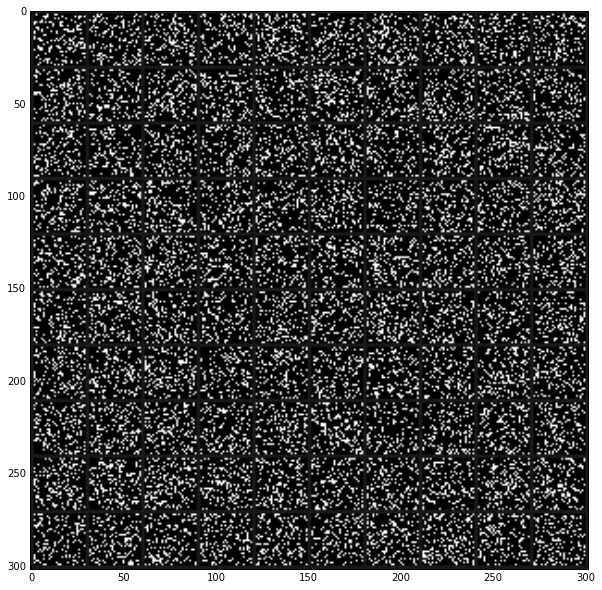

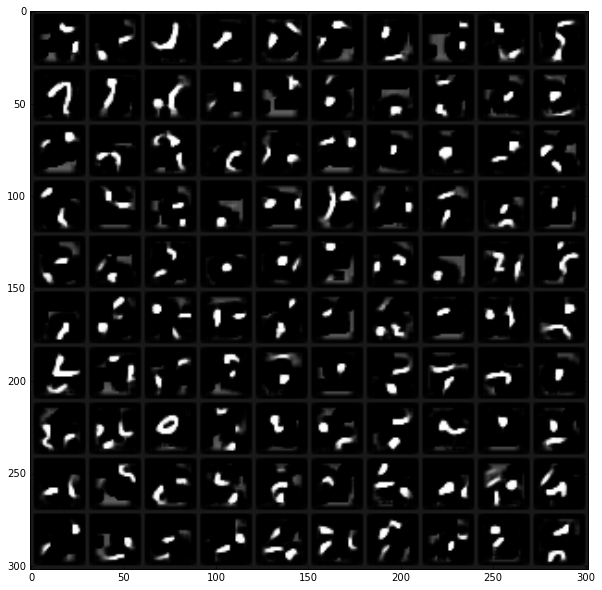

In [25]:
# show images generated at last iteration
for s in (samples[0], samples[-1]):
    s = s * np.ones((1, 3, 1, 1))
    s = s.transpose((0, 2, 3, 1))
    fig = plt.figure(figsize=(10, 10))
    img = dispims_color(s, border=2, bordercolor=(0.1, 0.1, 0.1), )
    imsave('out.png', img)
    plt.imshow(img)

In [67]:
# sample samples and iterations
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
img = dispims_color(samples_, shape=(sw, sh))
imsave('out.png', img)
plt.imshow(img)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

## project into feature space

In [ ]:
hid = []
d = []
for i in range(1):
    d.append(capsule.preprocess(external_data).transpose((0, 2 ,3 , 1))  * np.ones((1, 1, 1, 3)))
    C = encode(capsule.preprocess(external_data))
    if type(C) == list:
        C = [c.reshape(c.shape[0], -1) for c in C]
        C = C[-1]
        #C = np.concatenate(C, axis=1)
        
    hid.append(C)
d = np.concatenate(d, axis=0)
print(hid[0].shape)
hid = np.concatenate(hid, axis=0)
hid = hid.reshape((hid.shape[0], -1))

In [ ]:
mf = PCA(n_components=2)
h2d = mf.fit_transform(hid)

In [ ]:
mf = PCA(n_components=2)
d2d = mf.fit_transform(d.reshape(d.shape[0], -1))

In [ ]:
img = image_scatter(h2d, d, 10)
imsave('out_scatter.png', img)
plt.imshow(img)
plt.show()

In [ ]:
img = image_scatter(d2d, d, 80)
imsave('out_scatter_data.png', img)
plt.imshow(img)
plt.show()

## transferability

In [ ]:
X_transf_orig = external_data[0:500]


X_transf_rec = X_transf_orig.copy().astype(np.float32)
X_transf_rec = X_transf_rec
imgs = []
for i in tqdm(range(100)):
    X_transf_rec = X_transf_rec + (capsule.reconstruct(X_transf_rec) - X_transf_rec)
    imgs.append(X_transf_rec.copy())
    
from scripts import imgtovideo
x = []
for img in imgs:
    img = img * np.ones((1, 3, 1, 1))
    img = img.transpose((0, 2, 3, 1))
    x.append(dispims_color(img))


In [ ]:
imgtovideo.imgs_to_video(x, out='out.mp4', verbose=1)

In [ ]:
X_transf = X_transf_orig.transpose((0, 2, 3, 1))
X_transf = X_transf * np.ones((1, 1, 1, 3))

X_transf_rec = X_transf_rec.transpose((0, 2, 3, 1))
X_transf_rec = X_transf_rec * np.ones((1, 1, 1, 3))

In [ ]:
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf_rec[0:500])
plt.imshow(img, cmap='gray')
plt.show()
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf[0:500])
plt.imshow(img, cmap='gray')
plt.show()

## forced generation

In [ ]:
import pickle
from lasagne import layers

def load_model(filename):
    data = pickle.load(open(filename))
    print()
    gen = data['generator']
    discr = data['discriminator']
    gen_weights = data['generator_weights']
    discr_weights = data['discriminator_weights']
    layers.set_all_param_values(gen, gen_weights)
    layers.set_all_param_values(discr, discr_weights)
    return gen, discr

In [ ]:
gen, discr = load_model('/home/mcherti/work/code/lasagne-dcgan/fonts.pkl')

## rnn

In [ ]:
X = T.tensor4()
Xinit = X
nb_steps = 4
for i in range(nb_steps):
    X = L.get_output(layers['output'], X)
score = L.get_output(discr, X)
loss = (score).mean()
grad = theano.grad(loss, Xinit)
get_grad = theano.function([Xinit], grad)
get_loss = theano.function([Xinit], loss)
get_gen = theano.function([Xinit], X)

In [ ]:
import scipy
def eval_loss(x0):
    x0 = x0.reshape((nb, c, w, h))
    return -get_loss(x0.astype(np.float32)).astype('float64')

def eval_grad(x0):
    x0 = x0.reshape((nb, c, w, h))
    return get_grad(x0.astype(np.float32)).flatten().astype('float64')

In [ ]:
nb = 100
x = np.random.uniform(size=(nb, c, w, h))
x = x.astype(np.float32)
for i in range(40):
    #x, _, _ = scipy.optimize.fmin_l_bfgs_b(eval_loss, x.flatten(), fprime=eval_grad, maxfun=1)
    #x = x.reshape((nb, c, w, h)).astype(np.float32)
    x += 0.1 * get_grad(x)
    print(get_loss(x))

In [ ]:
img = get_gen(x) * np.ones((1, 3, 1, 1))
img = img.transpose((0, 2, 3, 1))
fig = plt.figure(figsize=(10, 10))
img = dispims_color(img, border=1, bordercolor=(10, 10, 10))
plt.imshow(img)

In [ ]:
## classif

In [8]:
from datakit.mnist import MNIST
data = MNIST('train')
data.load()
X_train = data.X.reshape((data.X.shape[0], 1, 28, 28))
y_train = data.y
def transform(X):
    h = []
    for i in range(0, X.shape[0], 128):
        C = encode(X[i:i + 128])
        hh = np.concatenate([cc.max(axis=(2, 3)).reshape((cc.shape[0], -1)) for cc in C], axis=1)      
        h.append(hh)
    h = np.concatenate(h, axis=0)
    return h

X_train = transform(X_train)

data = MNIST('test')
data.load()
X_test = data.X.reshape((data.X.shape[0], 1, 28, 28))
X_test = transform(X_test)
y_test = data.y

In [ ]:
Xrec = capsule.reconstruct(data.)